In [4]:
import sys
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import matplotlib 

matplotlib.rc('font', family='AppleGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

# 1. 합성곱 층
: CNN의 가장 중요한 구성 요소이다.


1. 두 개의 샘플 이미지 로드한다.
2. 중앙 부분을 잘라 70 * 120 크기의 이미지 만든다.
3. 픽셀 값을 0-1로 조정 -> 255로 나누어 스케일링한다.<br>
   -> 각 채널의 픽셀 강도는 0에서 255 사이의 값을 가진 바이트 하나로 표현됨. 이 특성을 255로 나누어 0 - 1 사이의 실수로 바꿈


In [5]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

텐서플로 저수준 API 중 하나인 Conv2D() 함수를 사용해 이 필터를 두 이미지에 적용한다.

In [6]:
tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

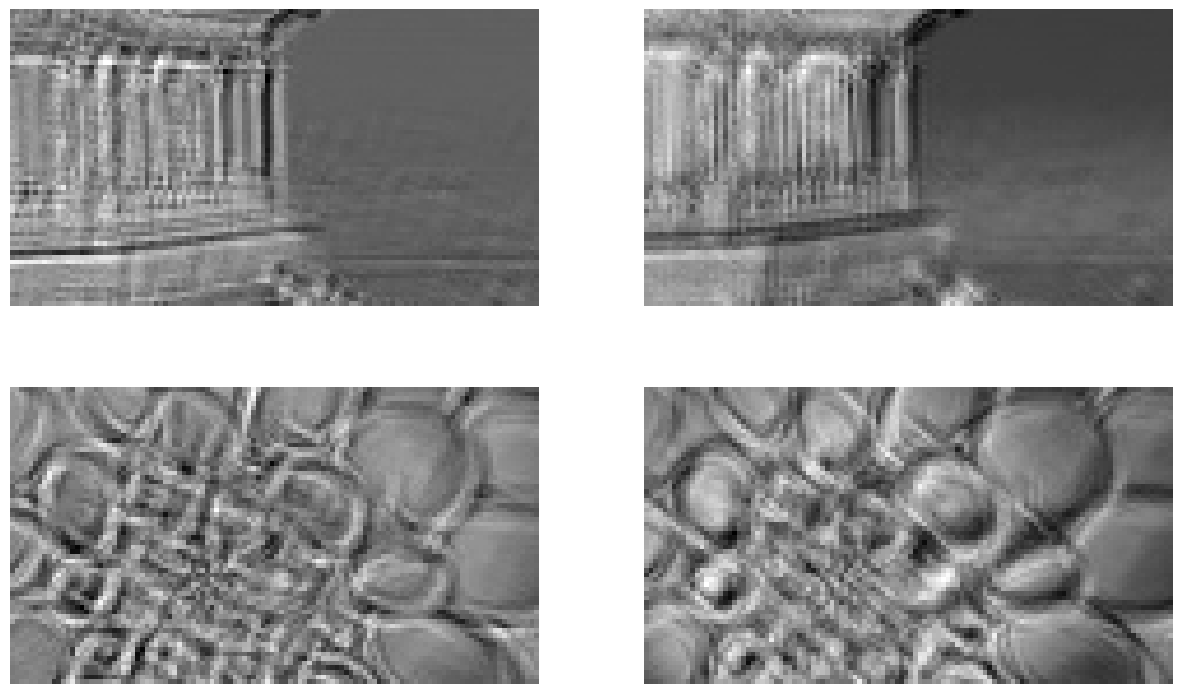

In [7]:

plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

제로 패딩 사용하기
- padding = "same"으로 할 경우 제로 패딩 적용
- padding = "valid"는 패딩 없음.

In [8]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                    padding="same")
fmaps = conv_layer(images)

In [11]:
# 추가 코드 - tf.nn.conv2d() 연산 사용 방법을 보여줍니다.

tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

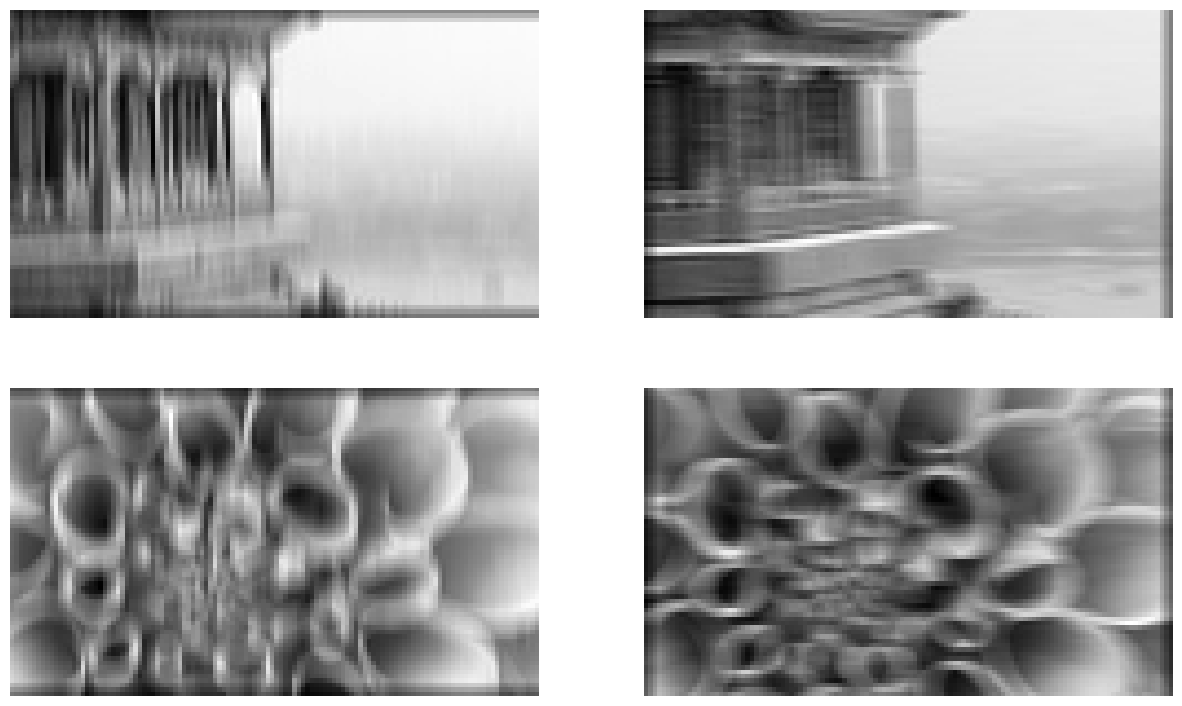

In [12]:
# 추가 코드 - 그림 14-5와 유사한 이미지를 얻기 위해 두 개의 필터를 수동으로 생성하는 방법을 보여줍니다.
import numpy as np

plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

위의 그림은 양 끝단에 검정색 선이 있다. 이는 제로 패딩을 사용했기 때문에 생긴 아티팩트이다.

# 2. 풀링 층
: CNN의 두 번째 일반 구성 요소이다. 이 층의 목적은 계산량과 메모리 사용량, 결과적으로 overfitting의 위험을 줄여주는 파라미터 수를 줄이기 위해 입력 이미지의 subsample 즉, 축소본을 만드는 것이다.
- 풀링 뉴런은 가중치가 없다. 즉, 최대나 평균 같은 합산 함수를 사용해 입력값을 더하는 것이 전부이다. 가중치가 없어서 그냥 '풀링 함수'라고 부르는 경우가 많다.
- 풀링은 단지 상태가 없는 슬라이딩 윈도우일 뿐이다.
- 풀링 층은 보통 모든 입력 채널에 독립적으로 적용되므로 출력의 깊이가 입력의 깊이와 같다.

  
아래 예에서는 풀링 커널과 스트라이드 2를 사용하며 패딩은 없다.<br>
스트라이드 2이므로 출력 이미지의 높이와 너비는 입력 이미지의 절반이 된다.

## 최대 풀링
평균 풀링 층을 만들려면 MaxPool2D 대신 AvgPool2D를 사용한다. 평균 풀링 층은 최댓값이 아닌 평균을 계산한다는 것만 뺴고 최대 풀링 층과 동이라하게 작동한다.   
하지만 평균 풀링은 평균을 계산하기 때문에 특징을 희석시키는 효과를 낸다. 반면 최대 풀링은 의미 없는 것은 모두 제거하고 가장 큰 특징만 유지하기 때문에 일반적으로 성능이 더 좋다.

In [13]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [14]:
output = max_pool(images)

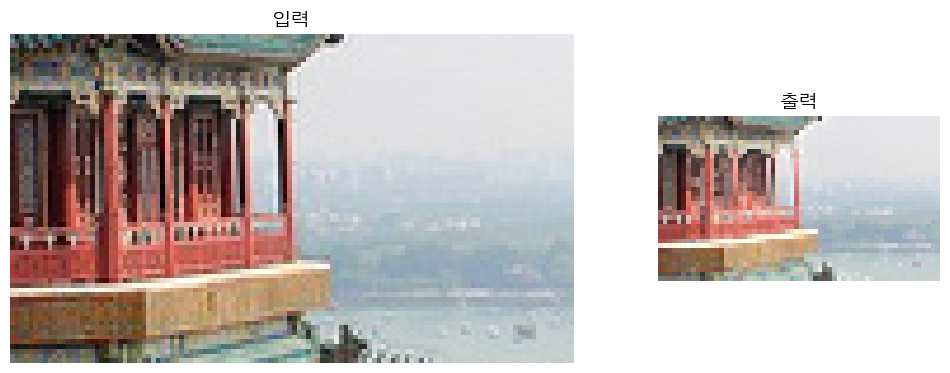

In [15]:
# 추가 코드 - 이 셀은 stride = 2인 최대 풀링이 어떻게 보이는지 보여줍니다.

import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("입력")
ax1.imshow(images[0])  # 첫 번째 이미지 그리기
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("출력")
ax2.imshow(output[0])  # 첫 번째 이미지의 출력을 그립니다.
ax2.axis("off")
plt.show()

# 3. CNN 구조
CNN 구조는 합성곱 층 몇 개 쌓고 각각 ReLU 층을 그 뒤에 놓고 -> 풀링 층 쌓고 -> 다시 합성 곱층(+ ReLU)을 몇 개 더 쌓고 -> 다시 풀링층 쌓는 식이다.
- 네트워크를 통과할 수록 이미지는 작아지지만, 합성곱 층 때문에 일반으로 점점 더 깊어져 더 많은 특성 맵을 가진다.
- 맨 위층에는 몇 개의 완전 연결 층(+ ReLU)으로 구성된 피드 포워드 신경망이 추가되고 마지막 층에서 예측을 출력한다.

In [16]:
# 추가 코드 - mnist 데이터 세트를 로드하고 입력에 채널 축을 추가합니다,
#          값을 0-1 범위로 스케일링하고 데이터셋을 분할합니다.
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [17]:
from functools import partial

tf.random.set_seed(42)  # 추가 코드 - 재현성 보장
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
model = tf.keras.Sequential([
    # 첫 번째 층은 64개의 큰 필터(7*7)와 스트라이드 1 사용
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    # 풀링 크기가 2인 최대 풀링 층을 추가하여 공간 방향 차원을 절반으로 줄임.
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    # 위의 과정 반복
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    # 두 개의 은닉층
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    # 출력층
    tf.keras.layers.Dense(units=10, activation="softmax")
])

CNN이 출력층에 다다를수록 필터 개수가 늘어난다. (64 -> 128 -> 256) 풀링 층 다음에 필터 개수를 두 배로 늘리는 것이 일반적인 방법이다.

In [18]:
# 추가 코드 - 모델을 컴파일, 훈련, 평가하고 예측을 만듭니다.
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]  # 새 이미지가 있다고 가정합니다.
y_pred = model.predict(X_new)

Epoch 1/10


2023-08-14 15:17:54.825336: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1719/1719 [==============================] - 44s 24ms/step - loss: 114.0584 - accuracy: 0.6198 - val_loss: 66.8641 - val_accuracy: 0.8048
Epoch 2/10
1719/1719 [==============================] - 43s 25ms/step - loss: 308.0623 - accuracy: 0.7561 - val_loss: 153.4058 - val_accuracy: 0.7912
Epoch 3/10
1719/1719 [==============================] - 43s 25ms/step - loss: 570.8392 - accuracy: 0.7674 - val_loss: 402.6089 - val_accuracy: 0.8138
Epoch 4/10
1719/1719 [==============================] - 42s 25ms/step - loss: 2283.8230 - accuracy: 0.7645 - val_loss: 1587.8547 - val_accuracy: 0.8218
Epoch 5/10
1719/1719 [==============================] - 43s 25ms/step - loss: 13352.4326 - accuracy: 0.7807 - val_loss: 2034.9514 - val_accuracy: 0.8340
Epoch 6/10
1719/1719 [==============================] - 42s 24ms/step - loss: 5040.3374 - accuracy: 0.7851 - val_loss: 6374.4282 - val_accuracy: 0.8412
Epoch 7/10
1719/1719 [==============================] - 41s 24ms/step - loss: 15873.2432 - accuracy: 0.78

# 4. 